<a href="https://colab.research.google.com/github/xandreiAThome/philippine-language-clustering/blob/main/language-clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Philippine Languages Clustering

### Setup


Clone the repo files and install required python libraries

In [19]:
repo = "https://github.com/xandreiAThome/philippine-language-clustering"

In [20]:
import os
import shutil

repo_name = repo.split('/')[-1]

if os.path.exists(repo_name):
    shutil.rmtree(repo_name)
    print(f"Removed existing directory: {repo_name}")

!git clone {repo}

Cloning into 'philippine-language-clustering'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 5), reused 6 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 480.28 KiB | 4.53 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [21]:
%cd philippine-language-clustering/

/content/drive/MyDrive/ph-lang-clustering/data/Verses/philippine-language-clustering


In [22]:
!pip install -r requirements.txt

In [31]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from rapidfuzz import process, fuzz
import seaborn as sns

This notebook explores the relationships between the different Philippine languages and some foreign languages using different computational techniques to quantify their similarity in language features.

One way to compare language similarity is to compute for the lexical similarity of the words used in the languages. We can compute for the lexical similarity of the 16 languages in our dataset against each other.

## Lexical Similarity


We will use the Levenshtein distance in order to compute the lexical similarity between two languages in our dataset. Levenshtein distance is the measure of the fewest number of single character modification that will transform one word into another (Citation needed).



First we need to transform the tsv file containing the verses of the bible in each of the 16 languages into a word list. Access the dataset in your google drive and cd to the directory.

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
%cd ../drive/MyDrive/ph-lang-clustering/data/Verses/

/content/drive/MyDrive/ph-lang-clustering/data/Verses


In [47]:
%ls

Bikolano.tsv   Ilonggo.tsv      philippine-language-clustering/  Waray.tsv
Cebuano.tsv    Ivatan.tsv       Romblomanon.tsv                  Yami.tsv
Chavacano.tsv  Kapampangan.tsv  Spanish.tsv
English.tsv    Mansaka.tsv      Tagalog.tsv
Ilokano.tsv    Pangasinan.tsv   Tausug.tsv


Load the tsv files into a list.

In [48]:
# Search for .tsv files in the current working directory
tsv_files = list(Path(".").glob("*.tsv"))

# Check if the list is not empty before printing
if tsv_files:
    print("Printing 3 of the the following .tsv files:")
    for i in range(min(3, len(tsv_files))):
        print(tsv_files[i].name)
else:
    print("No .tsv files found in the current directory.")

Printing 3 of the the following .tsv files:
Mansaka.tsv
Chavacano.tsv
Romblomanon.tsv


### Cleaning and Processing the Data

Now that the tsv files are loaded we need to clean the data to remove any non alphabetical characters and lowercase each word. We will create a frequency table alongside the wordlist using a DataFrame.

In [49]:
lang_freq_tables = {}

for path in tqdm(tsv_files, desc="Processing languages"):
    print(f"\n📖 Processing {path}...")

    # Read file and handle missing columns
    df = pd.read_csv(path, sep="\t", dtype=str)
    if "Text" not in df.columns:
        raise ValueError(f"File {path.name} must contain a 'Text' column.")

    counter = Counter()

    # Process line by line
    for verse in df["Text"].dropna():
        words = verse.split()
        counter.update(words)

    # Save as frequency table
    wdf = pd.DataFrame(counter.items(), columns=["word", "count"])
    wdf = wdf.sort_values("count", ascending=False).reset_index(drop=True)

    # Get the language name from the filename
    lang = path.stem

    # Add the language name as a column to the dataframe
    wdf['language'] = lang

    # Add the dataframe to the dictionary with the language name as the key
    lang_freq_tables[lang] = wdf

    print(f"Processed {len(wdf)} unique words for {lang}")

Processing languages:  12%|█▎        | 2/16 [00:00<00:01, 12.91it/s]


📖 Processing Mansaka.tsv...
Processed 14241 unique words for Mansaka

📖 Processing Chavacano.tsv...
Processed 8390 unique words for Chavacano

📖 Processing Romblomanon.tsv...


Processing languages:  25%|██▌       | 4/16 [00:00<00:00, 13.42it/s]

Processed 13706 unique words for Romblomanon

📖 Processing Ivatan.tsv...
Processed 12461 unique words for Ivatan

📖 Processing Spanish.tsv...
Processed 59950 unique words for Spanish

📖 Processing English.tsv...


Processing languages:  44%|████▍     | 7/16 [00:00<00:01,  6.07it/s]

Processed 36081 unique words for English

📖 Processing Kapampangan.tsv...
Processed 32692 unique words for Kapampangan

📖 Processing Waray.tsv...


Processing languages:  50%|█████     | 8/16 [00:01<00:01,  5.38it/s]

Processed 44493 unique words for Waray

📖 Processing Pangasinan.tsv...


Processing languages:  56%|█████▋    | 9/16 [00:01<00:01,  5.15it/s]

Processed 41416 unique words for Pangasinan

📖 Processing Tagalog.tsv...


Processing languages:  62%|██████▎   | 10/16 [00:01<00:01,  4.82it/s]

Processed 43432 unique words for Tagalog

📖 Processing Yami.tsv...
Processed 11308 unique words for Yami

📖 Processing Cebuano.tsv...


Processing languages:  75%|███████▌  | 12/16 [00:01<00:00,  5.54it/s]

Processed 35180 unique words for Cebuano

📖 Processing Ilokano.tsv...


Processing languages:  88%|████████▊ | 14/16 [00:02<00:00,  5.73it/s]

Processed 65197 unique words for Ilokano

📖 Processing Tausug.tsv...
Processed 14361 unique words for Tausug

📖 Processing Ilonggo.tsv...


Processing languages:  94%|█████████▍| 15/16 [00:02<00:00,  4.47it/s]

Processed 38781 unique words for Ilonggo

📖 Processing Bikolano.tsv...


Processing languages: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]

Processed 37563 unique words for Bikolano


One can see that the number of unique words differ from language to language. The languages with the fewest words are those that did not have available translations for many of the chapters in the New Testament.

In [53]:
# Show the number of words for all languages
for lang, df in lang_freq_tables.items():
    print(f"{lang}: {len(df)} words")

Mansaka: 14241 words
Chavacano: 8390 words
Romblomanon: 13706 words
Ivatan: 12461 words
Spanish: 59950 words
English: 36081 words
Kapampangan: 32692 words
Waray: 44493 words
Pangasinan: 41416 words
Tagalog: 43432 words
Yami: 11308 words
Cebuano: 35180 words
Ilokano: 65197 words
Tausug: 14361 words
Ilonggo: 38781 words
Bikolano: 37563 words


### Computing for the Levenshtein Distance

We will compute for the Levenshtein distance for words between two languages. As computing for all the words for each language is too computationally expensive, we will randomly sample a word with a limited sample size. The average Levenshtein distance between two languages will then be the lexical similarity of the two.

In [51]:
wordlists = {lang: lang_freq_tables[lang]["word"].tolist() for lang in langs}

def lexical_similarity(words_a, words_b, sample_size=10000):
    """
    Compute average Levenshtein similarity between two wordlists.
    """
    # Extract the 'word' column from the frequency tables

    # Limit to sample size for performance
    if len(words_a) > sample_size:
        words_a = np.random.choice(words_a, sample_size, replace=False)
    if len(words_b) > sample_size:
        words_b = np.random.choice(words_b, sample_size, replace=False)

    scores = []
    for w in words_a:
        best_match = process.extractOne(w, words_b, scorer=fuzz.ratio)
        if best_match:
            scores.append(best_match[1])
    return np.mean(scores)

def compute_pair(lang_a, lang_b):
    words_a = wordlists[lang_a]
    words_b = wordlists[lang_b]
    sim = lexical_similarity(words_a, words_b)
    return (lang_a, lang_b, sim)

In [52]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import combinations

langs = list(lang_freq_tables.keys())
sim_matrix = pd.DataFrame(index=langs, columns=langs, dtype=float)

with ProcessPoolExecutor() as executor:
    futures = {
        executor.submit(compute_pair, lang_a, lang_b): (lang_a, lang_b)
        for lang_a, lang_b in combinations(langs, 2)  # only upper triangle
    }

    for future in tqdm(as_completed(futures), total=len(futures), desc="Computing similarities"):
        lang_a, lang_b, sim = future.result()
        sim_matrix.loc[lang_a, lang_b] = sim
        sim_matrix.loc[lang_b, lang_a] = sim  # mirror for symmetry
        print(f"{lang_a} ↔ {lang_b}: {sim:.2f}%")

# Fill diagonals with 100%
np.fill_diagonal(sim_matrix.values, 100)

Computing similarities:   1%|          | 1/120 [00:10<21:09, 10.67s/it]

Mansaka ↔ Chavacano: 70.88%


Computing similarities:   2%|▏         | 2/120 [00:53<58:08, 29.56s/it]

Mansaka ↔ Romblomanon: 77.27%


Computing similarities:   2%|▎         | 3/120 [01:04<40:56, 21.00s/it]

Mansaka ↔ Ivatan: 75.34%


Computing similarities:   3%|▎         | 4/120 [01:51<1:00:22, 31.23s/it]

Mansaka ↔ Spanish: 67.14%


Computing similarities:   4%|▍         | 5/120 [02:03<46:33, 24.29s/it]  

Mansaka ↔ English: 65.31%


Computing similarities:   5%|▌         | 6/120 [02:58<1:05:57, 34.72s/it]

Mansaka ↔ Kapampangan: 75.42%


Computing similarities:   6%|▌         | 7/120 [03:13<53:16, 28.29s/it]  

Mansaka ↔ Waray: 76.87%


Computing similarities:   7%|▋         | 8/120 [03:53<1:00:07, 32.21s/it]

Mansaka ↔ Pangasinan: 75.24%


Computing similarities:   8%|▊         | 9/120 [04:07<49:07, 26.56s/it]  

Mansaka ↔ Tagalog: 75.78%


Computing similarities:   8%|▊         | 10/120 [04:47<55:49, 30.45s/it]

Mansaka ↔ Yami: 73.95%


Computing similarities:   9%|▉         | 11/120 [05:01<46:20, 25.51s/it]

Mansaka ↔ Cebuano: 77.13%


Computing similarities:  10%|█         | 12/120 [05:43<54:50, 30.47s/it]

Mansaka ↔ Ilokano: 73.82%


Computing similarities:  11%|█         | 13/120 [05:56<45:15, 25.38s/it]

Mansaka ↔ Tausug: 74.83%


Computing similarities:  12%|█▏        | 14/120 [06:40<54:36, 30.91s/it]

Mansaka ↔ Ilonggo: 77.23%


Computing similarities:  12%|█▎        | 15/120 [06:52<44:05, 25.19s/it]

Mansaka ↔ Bikolano: 76.63%


Computing similarities:  13%|█▎        | 16/120 [07:24<47:01, 27.13s/it]

Chavacano ↔ Romblomanon: 74.17%


Computing similarities:  14%|█▍        | 17/120 [07:35<38:25, 22.38s/it]

Chavacano ↔ Ivatan: 74.57%


Computing similarities:  15%|█▌        | 18/120 [08:07<42:57, 25.27s/it]

Chavacano ↔ Spanish: 81.09%


Computing similarities:  16%|█▌        | 19/120 [08:22<37:15, 22.14s/it]

Chavacano ↔ English: 73.66%


Computing similarities:  17%|█▋        | 20/120 [08:59<44:26, 26.66s/it]

Chavacano ↔ Kapampangan: 73.01%


Computing similarities:  18%|█▊        | 21/120 [09:18<40:04, 24.29s/it]

Chavacano ↔ Waray: 72.15%


Computing similarities:  18%|█▊        | 22/120 [09:44<40:31, 24.81s/it]

Chavacano ↔ Pangasinan: 72.04%


Computing similarities:  19%|█▉        | 23/120 [10:03<37:17, 23.07s/it]

Chavacano ↔ Tagalog: 71.64%


Computing similarities:  20%|██        | 24/120 [10:29<38:12, 23.88s/it]

Chavacano ↔ Yami: 67.42%


Computing similarities:  21%|██        | 25/120 [10:46<34:57, 22.08s/it]

Chavacano ↔ Cebuano: 72.06%


Computing similarities:  22%|██▏       | 26/120 [11:14<37:23, 23.87s/it]

Chavacano ↔ Ilokano: 70.74%


Computing similarities:  22%|██▎       | 27/120 [11:34<34:53, 22.51s/it]

Chavacano ↔ Tausug: 64.29%


Computing similarities:  23%|██▎       | 28/120 [12:02<36:54, 24.08s/it]

Chavacano ↔ Ilonggo: 71.93%


Computing similarities:  24%|██▍       | 29/120 [12:19<33:23, 22.02s/it]

Chavacano ↔ Bikolano: 73.14%


Computing similarities:  25%|██▌       | 30/120 [12:54<38:57, 25.97s/it]

Romblomanon ↔ Ivatan: 74.46%


Computing similarities:  26%|██▌       | 31/120 [13:13<35:22, 23.84s/it]

Romblomanon ↔ Spanish: 65.90%


Computing similarities:  27%|██▋       | 32/120 [13:50<41:01, 27.97s/it]

Romblomanon ↔ English: 65.15%


Computing similarities:  28%|██▊       | 33/120 [14:18<40:26, 27.89s/it]

Romblomanon ↔ Kapampangan: 74.45%


Computing similarities:  28%|██▊       | 34/120 [14:58<45:01, 31.41s/it]

Romblomanon ↔ Waray: 79.57%


Computing similarities:  29%|██▉       | 35/120 [15:13<37:32, 26.50s/it]

Romblomanon ↔ Pangasinan: 74.12%


Computing similarities:  30%|███       | 36/120 [15:51<41:56, 29.96s/it]

Romblomanon ↔ Tagalog: 77.28%


Computing similarities:  31%|███       | 37/120 [16:06<35:09, 25.41s/it]

Romblomanon ↔ Yami: 70.37%


Computing similarities:  32%|███▏      | 38/120 [16:44<39:54, 29.20s/it]

Romblomanon ↔ Cebuano: 79.70%


Computing similarities:  32%|███▎      | 39/120 [17:02<34:59, 25.91s/it]

Romblomanon ↔ Ilokano: 74.10%


Computing similarities:  33%|███▎      | 40/120 [17:40<39:30, 29.64s/it]

Romblomanon ↔ Tausug: 73.53%


Computing similarities:  34%|███▍      | 41/120 [17:57<34:06, 25.90s/it]

Romblomanon ↔ Ilonggo: 80.12%


Computing similarities:  35%|███▌      | 42/120 [18:35<38:06, 29.31s/it]

Romblomanon ↔ Bikolano: 78.25%


Computing similarities:  36%|███▌      | 43/120 [18:51<32:42, 25.48s/it]

Ivatan ↔ Spanish: 67.33%


Computing similarities:  37%|███▋      | 44/120 [19:31<37:32, 29.64s/it]

Ivatan ↔ English: 66.01%


Computing similarities:  38%|███▊      | 45/120 [19:56<35:30, 28.41s/it]

Ivatan ↔ Kapampangan: 73.16%


Computing similarities:  38%|███▊      | 46/120 [20:39<40:11, 32.59s/it]

Ivatan ↔ Waray: 73.47%


Computing similarities:  39%|███▉      | 47/120 [20:51<32:22, 26.62s/it]

Ivatan ↔ Pangasinan: 74.79%


Computing similarities:  40%|████      | 48/120 [21:32<37:09, 30.96s/it]

Ivatan ↔ Tagalog: 73.47%


Computing similarities:  41%|████      | 49/120 [21:43<29:17, 24.75s/it]

Ivatan ↔ Yami: 77.63%


Computing similarities:  42%|████▏     | 50/120 [22:26<35:26, 30.37s/it]

Ivatan ↔ Cebuano: 73.34%


Computing similarities:  42%|████▎     | 51/120 [22:37<28:23, 24.69s/it]

Ivatan ↔ Ilokano: 72.83%


Computing similarities:  43%|████▎     | 52/120 [23:23<35:06, 30.97s/it]

Ivatan ↔ Tausug: 69.75%


Computing similarities:  44%|████▍     | 53/120 [23:34<27:57, 25.04s/it]

Ivatan ↔ Ilonggo: 72.72%


Computing similarities:  45%|████▌     | 54/120 [24:18<33:41, 30.62s/it]

Ivatan ↔ Bikolano: 74.54%


Computing similarities:  46%|████▌     | 55/120 [24:30<27:03, 24.97s/it]

Spanish ↔ English: 70.20%


Computing similarities:  47%|████▋     | 56/120 [25:24<35:53, 33.65s/it]

Spanish ↔ Kapampangan: 67.06%


Computing similarities:  48%|████▊     | 57/120 [25:40<29:47, 28.37s/it]

Spanish ↔ Waray: 66.26%


Computing similarities:  48%|████▊     | 58/120 [26:19<32:42, 31.65s/it]

Spanish ↔ Pangasinan: 66.64%


Computing similarities:  49%|████▉     | 59/120 [26:34<26:58, 26.53s/it]

Spanish ↔ Tagalog: 65.57%


Computing similarities:  50%|█████     | 60/120 [27:12<30:04, 30.08s/it]

Spanish ↔ Yami: 62.46%


Computing similarities:  51%|█████     | 61/120 [27:27<25:03, 25.49s/it]

Spanish ↔ Cebuano: 65.86%


Computing similarities:  52%|█████▏    | 62/120 [28:08<29:10, 30.18s/it]

Spanish ↔ Ilokano: 65.32%


Computing similarities:  52%|█████▎    | 63/120 [28:24<24:46, 26.08s/it]

Spanish ↔ Tausug: 58.47%


Computing similarities:  53%|█████▎    | 64/120 [29:06<28:35, 30.63s/it]

Spanish ↔ Ilonggo: 66.01%


Computing similarities:  54%|█████▍    | 65/120 [29:20<23:33, 25.70s/it]

Spanish ↔ Bikolano: 67.19%


Computing similarities:  55%|█████▌    | 66/120 [30:14<30:46, 34.19s/it]

English ↔ Kapampangan: 67.72%


Computing similarities:  56%|█████▌    | 67/120 [30:36<26:55, 30.48s/it]

English ↔ Waray: 66.33%


Computing similarities:  57%|█████▋    | 68/120 [31:10<27:24, 31.62s/it]

English ↔ Pangasinan: 67.26%


Computing similarities:  57%|█████▊    | 69/120 [31:31<24:05, 28.35s/it]

English ↔ Tagalog: 66.46%


Computing similarities:  58%|█████▊    | 70/120 [32:04<24:55, 29.91s/it]

English ↔ Yami: 62.82%


Computing similarities:  59%|█████▉    | 71/120 [32:25<22:09, 27.14s/it]

English ↔ Cebuano: 66.84%


Computing similarities:  60%|██████    | 72/120 [33:01<23:59, 30.00s/it]

English ↔ Ilokano: 65.70%


Computing similarities:  61%|██████    | 73/120 [33:23<21:25, 27.35s/it]

English ↔ Tausug: 59.78%


Computing similarities:  62%|██████▏   | 74/120 [34:00<23:20, 30.45s/it]

English ↔ Ilonggo: 66.03%


Computing similarities:  62%|██████▎   | 75/120 [34:19<20:12, 26.94s/it]

English ↔ Bikolano: 67.37%


Computing similarities:  63%|██████▎   | 76/120 [35:12<25:33, 34.85s/it]

Kapampangan ↔ Waray: 75.40%


Computing similarities:  64%|██████▍   | 77/120 [35:16<18:12, 25.40s/it]

Kapampangan ↔ Pangasinan: 76.83%


Computing similarities:  65%|██████▌   | 78/120 [36:07<23:15, 33.22s/it]

Kapampangan ↔ Tagalog: 77.90%


Computing similarities:  66%|██████▌   | 79/120 [36:09<16:16, 23.82s/it]

Kapampangan ↔ Yami: 71.16%


Computing similarities:  67%|██████▋   | 80/120 [37:01<21:24, 32.12s/it]

Kapampangan ↔ Cebuano: 76.29%


Computing similarities:  68%|██████▊   | 81/120 [37:05<15:32, 23.90s/it]

Kapampangan ↔ Ilokano: 74.28%


Computing similarities:  68%|██████▊   | 82/120 [37:57<20:20, 32.13s/it]

Kapampangan ↔ Tausug: 73.80%


Computing similarities:  69%|██████▉   | 83/120 [38:03<15:02, 24.40s/it]

Kapampangan ↔ Ilonggo: 76.11%


Computing similarities:  70%|███████   | 84/120 [38:52<19:06, 31.86s/it]

Kapampangan ↔ Bikolano: 76.88%


Computing similarities:  71%|███████   | 85/120 [38:58<14:01, 24.04s/it]

Waray ↔ Pangasinan: 74.34%


Computing similarities:  72%|███████▏  | 86/120 [39:46<17:45, 31.35s/it]

Waray ↔ Tagalog: 76.77%


Computing similarities:  72%|███████▎  | 87/120 [39:52<12:54, 23.48s/it]

Waray ↔ Yami: 69.79%


Computing similarities:  73%|███████▎  | 88/120 [40:40<16:30, 30.95s/it]

Waray ↔ Cebuano: 80.13%


Computing similarities:  74%|███████▍  | 89/120 [40:49<12:35, 24.37s/it]

Waray ↔ Ilokano: 74.09%


Computing similarities:  75%|███████▌  | 90/120 [41:38<15:48, 31.62s/it]

Waray ↔ Tausug: 71.93%


Computing similarities:  76%|███████▌  | 91/120 [41:46<11:58, 24.76s/it]

Waray ↔ Ilonggo: 78.33%


Computing similarities:  77%|███████▋  | 92/120 [42:33<14:33, 31.21s/it]

Waray ↔ Bikolano: 78.31%


Computing similarities:  78%|███████▊  | 93/120 [42:43<11:11, 24.87s/it]

Pangasinan ↔ Tagalog: 75.48%


Computing similarities:  78%|███████▊  | 94/120 [43:26<13:11, 30.44s/it]

Pangasinan ↔ Yami: 72.10%


Computing similarities:  79%|███████▉  | 95/120 [43:36<10:07, 24.31s/it]

Pangasinan ↔ Cebuano: 74.83%


Computing similarities:  80%|████████  | 96/120 [44:22<12:20, 30.85s/it]

Pangasinan ↔ Ilokano: 74.69%


Computing similarities:  81%|████████  | 97/120 [44:33<09:29, 24.77s/it]

Pangasinan ↔ Tausug: 70.55%


Computing similarities:  82%|████████▏ | 98/120 [45:20<11:32, 31.49s/it]

Pangasinan ↔ Ilonggo: 74.31%


Computing similarities:  82%|████████▎ | 99/120 [45:29<08:39, 24.73s/it]

Pangasinan ↔ Bikolano: 75.56%


Computing similarities:  83%|████████▎ | 100/120 [46:13<10:13, 30.65s/it]

Tagalog ↔ Yami: 71.02%


Computing similarities:  84%|████████▍ | 101/120 [46:22<07:38, 24.14s/it]

Tagalog ↔ Cebuano: 77.92%


Computing similarities:  85%|████████▌ | 102/120 [47:10<09:24, 31.34s/it]

Tagalog ↔ Ilokano: 74.48%


Computing similarities:  86%|████████▌ | 103/120 [47:19<06:56, 24.51s/it]

Tagalog ↔ Tausug: 73.56%


Computing similarities:  87%|████████▋ | 104/120 [48:07<08:27, 31.69s/it]

Tagalog ↔ Ilonggo: 77.62%


Computing similarities:  88%|████████▊ | 105/120 [48:15<06:05, 24.38s/it]

Tagalog ↔ Bikolano: 78.90%


Computing similarities:  88%|████████▊ | 106/120 [49:02<07:17, 31.28s/it]

Yami ↔ Cebuano: 70.65%


Computing similarities:  89%|████████▉ | 107/120 [49:11<05:18, 24.51s/it]

Yami ↔ Ilokano: 70.00%


Computing similarities:  90%|█████████ | 108/120 [50:00<06:21, 31.80s/it]

Yami ↔ Tausug: 68.49%


Computing similarities:  91%|█████████ | 109/120 [50:09<04:35, 25.08s/it]

Yami ↔ Ilonggo: 69.86%


Computing similarities:  92%|█████████▏| 110/120 [50:55<05:13, 31.35s/it]

Yami ↔ Bikolano: 70.74%


Computing similarities:  92%|█████████▎| 111/120 [51:06<03:45, 25.10s/it]

Cebuano ↔ Ilokano: 74.90%


Computing similarities:  93%|█████████▎| 112/120 [51:52<04:12, 31.54s/it]

Cebuano ↔ Tausug: 72.85%


Computing similarities:  94%|█████████▍| 113/120 [52:01<02:52, 24.66s/it]

Cebuano ↔ Ilonggo: 80.36%


Computing similarities:  95%|█████████▌| 114/120 [52:46<03:05, 30.96s/it]

Cebuano ↔ Bikolano: 78.24%


Computing similarities:  96%|█████████▌| 115/120 [52:58<02:05, 25.03s/it]

Ilokano ↔ Tausug: 69.21%


Computing similarities:  97%|█████████▋| 116/120 [53:44<02:05, 31.30s/it]

Ilokano ↔ Ilonggo: 72.07%


Computing similarities:  98%|█████████▊| 117/120 [53:54<01:14, 24.95s/it]

Ilokano ↔ Bikolano: 73.54%


Computing similarities:  98%|█████████▊| 118/120 [54:42<01:03, 31.93s/it]

Tausug ↔ Ilonggo: 74.20%


Computing similarities:  99%|█████████▉| 119/120 [54:52<00:25, 25.31s/it]

Tausug ↔ Bikolano: 73.04%


Computing similarities: 100%|██████████| 120/120 [55:17<00:00, 27.64s/it]

Ilonggo ↔ Bikolano: 78.15%


Though this will not be a 100% accurate similarity matrix because it is only a sample of each languages, it can give a general idea on the lexical similarity between each of the languages. And increasing the sample size will increase the overall accuracy of the score. For this, we used 10000 words per language, though some languages have less than that.

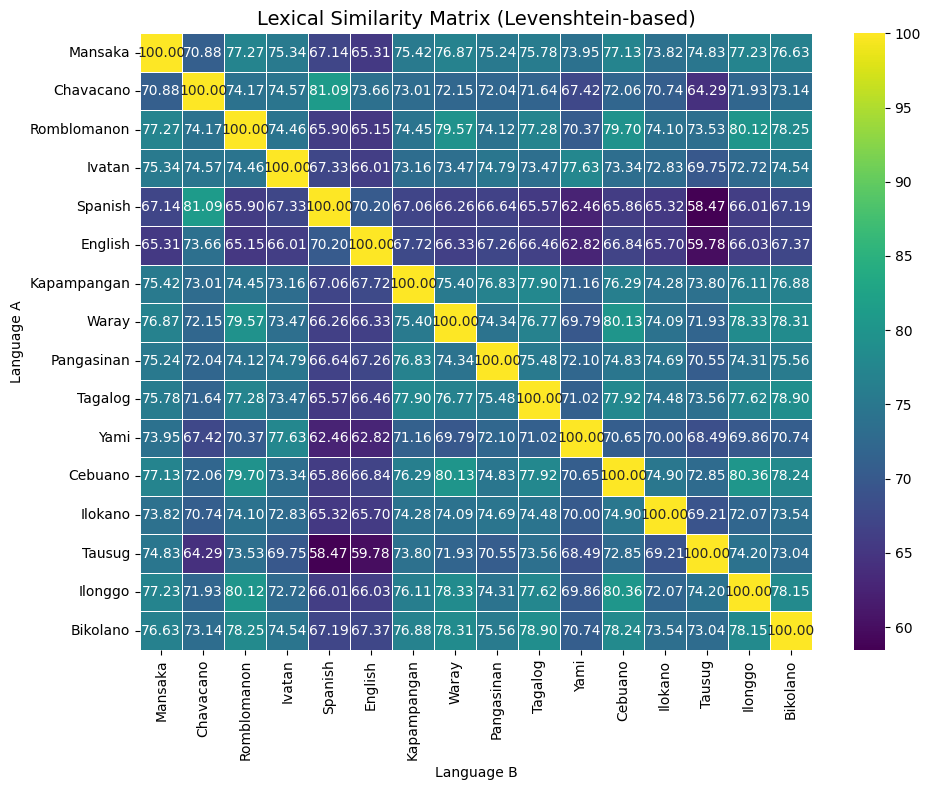

In [55]:

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix.astype(float), annot=True, cmap="viridis", fmt=".2f", linewidths=.5)
plt.title("Lexical Similarity Matrix (Levenshtein-based)", fontsize=14)
plt.xlabel("Language B")
plt.ylabel("Language A")
plt.tight_layout()
plt.show()

We can see that languages in the Philippines have a much higher lexical similarity than the foreign languages, specifically English and Spanish. This is reflected where the heatmap forms a cross shape where Spanish and English has a lower similarity measure towards the Philippine Languages, though there are exceptions. And the Austronesian adjacent language Yami has a similarity measure near that of other Philippine Languages. While Chavacano has a very high similarity measure to Spanish, reflecting its origins as a  Spanish-based creole language.

Now that we have computed for the similarity matrix between the 16 languages, we can plot the result using a dendogram to be able to more easily distinguish the hierarchy of which languages are more similar to each other.

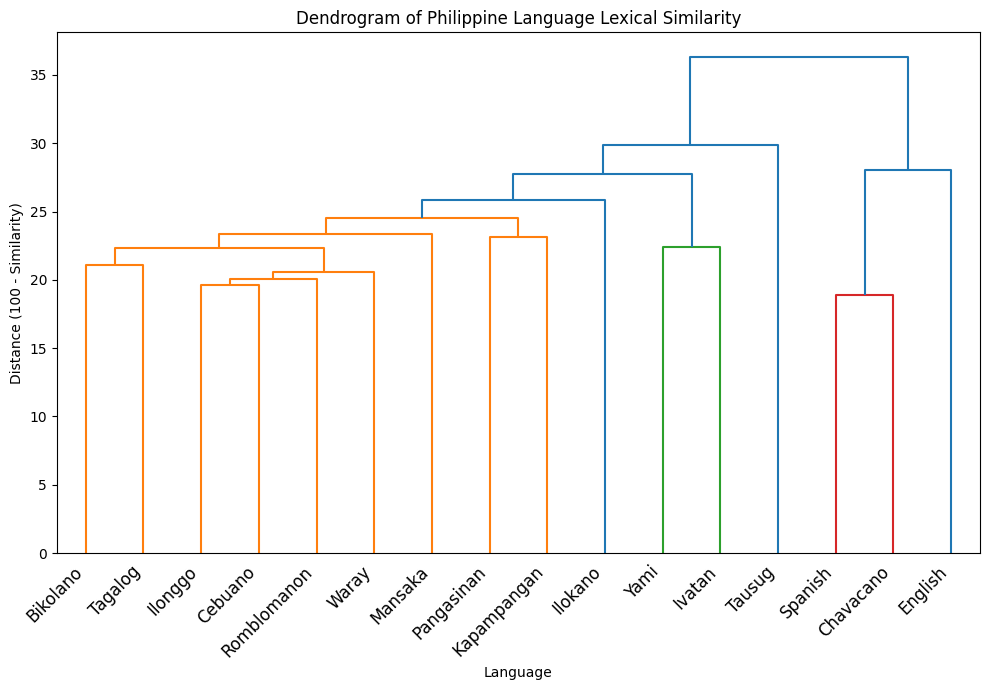

In [57]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Convert similarity to distance
# Assuming 100% similarity means 0 distance
distance_matrix = 100 - sim_matrix

# Convert the distance matrix to a condensed distance matrix required by linkage
condensed_distance_matrix = squareform(distance_matrix)

linked = linkage(condensed_distance_matrix, 'weighted')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=langs,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram of Philippine Language Lexical Similarity')
plt.xlabel('Language')
plt.ylabel('Distance (100 - Similarity)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()